In [1]:
from resample.bootstrap import jackknife
import numpy as np
import numba as nb
from typing import Callable, Optional, Tuple
from timeit import timeit
from matplotlib import pyplot as plt

In [2]:
@nb.njit(nogil=True)
def _jackknife_jit(a: np.ndarray):
    n = len(a)
    x = np.empty((n, n - 1), dtype=a.dtype)
    for i in range(n):
        for j in range(n-1):
            shift = 0 if j < i else 1
            x[i, j] = a[j + shift]
    return x


@nb.njit
def _jackknife_gen(a):
    n = len(a)
    x = np.empty(n - 1, a.dtype)
    for i in range(n - 1):
        x[i] = a[i + 1]
    yield x.view(x.dtype)

    # update needs to change values only up to i
    # for a = [0, 1, 2, 3]
    # x0 = [1, 2, 3]
    # x1 = [0, 2, 3]
    # x2 = [0, 1, 3]
    # x3 = [0, 1, 2]
    for i in range(1, n):
        for j in range(i):
            x[j] = a[j]
        yield x.view(x.dtype)


def jackknife_jit(a: np.ndarray, f: Optional[Callable] = None) -> np.ndarray:
    if f is None:
        return _jackknife_jit(a)
    else:
        return np.asarray([f(x) for x in _jackknife_gen(a)])

    
# force compilation
jackknife_jit(np.random.randn(10));
jackknife_jit(np.random.randn(10), np.mean);

In [3]:
x = np.random.rand(10000)

In [4]:
%%timeit
jackknife(x)

1.31 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
jackknife(x, np.mean)

1.54 s ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
jackknife_jit(x)

358 ms ± 7.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
jackknife_jit(x, np.mean)

92.9 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
n = np.asarray(np.geomspace(3, 20000, 50), dtype=int)
times = {
    ("jackknife", "None"): np.empty(len(n)),
    ("jackknife", "np.mean"): np.empty(len(n)),
    ("jackknife_jit", "None"): np.empty(len(n)),
    ("jackknife_jit", "np.mean"): np.empty(len(n)),
}
for i, ni in enumerate(n):
    x = np.random.randn(ni)
    for s_fcn, s_arg in times:
        t = timeit(f"{s_fcn}(x, {s_arg})", f"from __main__ import {s_fcn}, x; import numpy as np", number=1)
        times[(s_fcn, s_arg)][i] = t
        print(ni, t)

3 0.0004140899999995895
3 0.00021348300000312292
3 9.76299999422281e-06
3 5.508899999995265e-05
3 0.00017323400000179845
3 0.00012603199999716708
3 8.08199999369208e-06
3 4.299700000132134e-05
4 0.0002041400000010185
4 0.00018420199999980014
4 7.050999997204599e-06
4 5.9395999997491344e-05
5 0.00011575100000271732
5 0.00035481900000178257
5 7.459000002540961e-06
5 5.342299999711031e-05
6 0.0001421530000058624
6 0.0002924260000014556
6 6.399000000101296e-06
6 7.316299999615694e-05
7 0.00017333699999966257
7 0.0002574199999969551
7 6.831000000317999e-06
7 6.381200000049603e-05
8 0.0003022260000022925
8 0.00020353600000078131
8 8.004000001449185e-06
8 7.340300000180378e-05
10 0.0002163969999955384
10 0.0004637499999944339
10 8.170000000973232e-06
10 9.033100000266359e-05
12 0.00038053799999460125
12 0.0004199520000014445
12 7.0159999978614e-06
12 9.949900000094658e-05
15 0.0006271529999963832
15 0.000672538999999972
15 1.0644000006720944e-05
15 0.00012099799999987226
18 0.0004593029999995

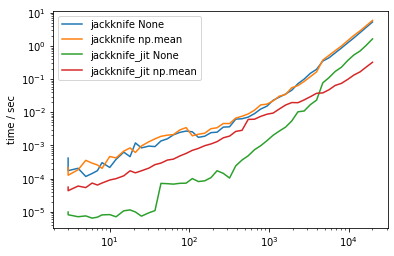

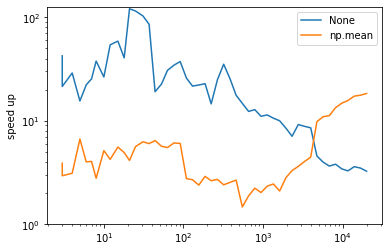

In [9]:
plt.figure()
for (s_fcn, s_arg), ts in times.items():
    plt.plot(n, ts, label=f"{s_fcn} {s_arg}")
plt.loglog()
plt.ylabel("time / sec")
plt.legend()

plt.figure()
plt.plot(n, times["jackknife", "None"] / times["jackknife_jit", "None"], label="None")
plt.plot(n, times["jackknife", "np.mean"] / times["jackknife_jit", "np.mean"], label="np.mean")
plt.ylim(1, None)
plt.ylabel("speed up")
plt.legend()
plt.loglog();

For large samples, creating a N x (N-1) array in memory becomes dangerous since the memory allocation may bring the computer down and very slow.